In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
import matplotlib as mpl
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
from matplotlib import font_manager
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
from spynal.spikes import density
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *

plt.style.use('../sci_style.py')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
# prop.get_name()

# Sample Data

## Get Data

In [3]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

# os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [5]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [6]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [7]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

## Plot

In [8]:
start_wake = 500
start_anesthesia = session_info['drugStart'][1] + 200

In [9]:
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'all'
}

In [10]:
# fig, axs = plt.subplots(8, 2, figsize=(15, 8))

# ylabel_fontsize = 11
# title_fontsize = 19

# areas = ['vlPFC', 'FEF', '7b', 'CPB']

# for j, area in enumerate(areas):
#     if area == 'all':
#         unit_indices = np.arange(len(electrode_info['area']))
#     else:
#         unit_indices = np.where(electrode_info['area'] == area)[0]

#     ax = axs[j][0]
#     inds = np.random.choice(unit_indices, size=(3,), replace=False)
#     for n, ind in enumerate(inds):
#         ax.plot(lfp[int(start_wake/dt):int((start_wake + 10)/dt), ind] - n*0.3, c='k', linewidth=0.6)
    
#     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     ax.set_ylabel(f"{area_labels[area]} LFP", fontsize=ylabel_fontsize)
    
#     if j == 0:
#         ax.set_title('Awake', fontsize=title_fontsize)
    
#     ax = axs[j][1]
#     inds = np.random.choice(unit_indices, size=(3,), replace=False)
#     for n, ind in enumerate(inds):
#         ax.plot(lfp[int(start_anesthesia/dt):int((start_anesthesia + 10)/dt), ind] - n*0.3, c='k', linewidth=0.6)
    
#     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     if j == 0:
#         ax.set_title('Unconscious', fontsize=title_fontsize)
    
#     ax = axs[j + 4][0]
#     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     ax.set_ylabel(f"{area_labels[area]} Spikes", fontsize=ylabel_fontsize, rotation='90')
    
#     if area == 'all':
#         unit_indices = np.arange(len(unit_info['area']))
#     else:
#         unit_indices = np.where(unit_info['area'] == area)[0]
#     unit_indices = np.random.choice(unit_indices, size=(30,), replace=False)
    
#     for n, unit_ind in enumerate(unit_indices):
#         spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_wake, spike_times[unit_ind] <= start_wake + 10)]
#         spike_ts = (spike_ts - start_wake)/dt
#         ax.scatter(spike_ts, [n]*len(spike_ts), c='k', s=3)

#     ax = axs[j + 4][1]
#     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     for n, unit_ind in enumerate(unit_indices):
#         spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_anesthesia, spike_times[unit_ind] <= start_anesthesia + 10)]
#         spike_ts = (spike_ts - start_wake)/dt
#         ax.scatter(spike_ts, [n]*len(spike_ts), c='k', s=3)
    
# plt.tight_layout()
# plt.show()

In [11]:
img_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images"

In [12]:
# %matplotlib inline
# fig = plt.figure(layout='constrained', figsize=(15, 8))
# subfigs = fig.subfigures(2, 1, hspace=0.07)

# ylabel_fontsize = 16
# superylabel_fontsize = 22
# title_fontsize = 22
# onplot_fontsize = 16
# shift = 0.2

# areas = ['vlPFC', 'FEF', '7b', 'CPB']
# axs = subfigs[0].subplots(4, 2, sharey=False)
# for j, area in enumerate(areas):
#     if area == 'all':
#         unit_indices = np.arange(len(electrode_info['area']))
#     else:
#         unit_indices = np.where(electrode_info['area'] == area)[0]

#     ax = axs[j][0]
#     inds = np.random.choice(unit_indices, size=(3,), replace=False)
#     for n, ind in enumerate(inds):
#         # print(lfp[int(start_wake/dt):int((start_wake + 10)/dt), ind].shape)
#         ax.plot(lfp[int(start_wake/dt):int((start_wake + 10)/dt), ind] - n*shift, c='k', linewidth=0.6)
    
#     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     ax.set_ylabel(f"{area_labels[area]}    ", fontsize=ylabel_fontsize, rotation=0)
    
#     if j == 0:
#         ax.set_title('Awake', fontsize=title_fontsize)
    
#     ax = axs[j][1]
#     inds = np.random.choice(unit_indices, size=(3,), replace=False)
#     for n, ind in enumerate(inds):
#         ax.plot(lfp[int(start_anesthesia/dt):int((start_anesthesia + 10)/dt), ind] - n*shift, c='k', linewidth=0.6)
    
#     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     if j == 0:
#         ax.set_title('Unconscious', fontsize=title_fontsize)
#         max_val = lfp[int(start_wake/dt):int((start_wake + 10)/dt), inds[-1]].max()
#         bar_verts = [max_val + 0.5, max_val + 1]
#         ax.plot([int(10/dt)*0.9, int(10/dt)*0.9], bar_verts, c='k', linewidth=1)
#         ax.text(int(10/dt)*0.91, np.mean(bar_verts), "500 mV", fontsize=onplot_fontsize)
# subfigs[0].text(-0.03, 0.5, "LFP", va='center', fontsize=superylabel_fontsize, rotation=90)

# axs = subfigs[1].subplots(4, 2)
# for j, area in enumerate(areas):
#     ax = axs[j][0]
#     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     ax.set_ylabel(f"{area_labels[area]}    ", fontsize=ylabel_fontsize, rotation=0)
    
#     if area == 'all':
#         unit_indices = np.arange(len(unit_info['area']))
#     else:
#         unit_indices = np.where(unit_info['area'] == area)[0]
#     unit_indices = np.random.choice(unit_indices, size=(30,), replace=False)
    
#     for n, unit_ind in enumerate(unit_indices):
#         spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_wake, spike_times[unit_ind] <= start_wake + 10)]
#         spike_ts = (spike_ts - start_wake)/dt
#         ax.scatter(spike_ts, [n]*len(spike_ts), c='k', s=3)

#     ax = axs[j][1]
#     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     for n, unit_ind in enumerate(unit_indices):
#         spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_anesthesia, spike_times[unit_ind] <= start_anesthesia + 10)]
#         spike_ts = (spike_ts - start_anesthesia)/dt
#         ax.scatter(spike_ts, [n]*len(spike_ts), c='k', s=3)
    
#     xmax = ax.get_xlim()[1]
#     ymin = ax.get_ylim()[0]
#     if j == 3:
# #         ax.set_title('Unconscious', fontsize=title_fontsize)
# #         bar_verts = [max_val + 0.5, max_val + 1]
#         ax.plot([xmax - 10000*0.15, xmax - 10000*0.05], [-2, -2], c='k', linewidth=1)
#         ax.text(xmax - 10000*0.1, -11, "1 sec", fontsize=onplot_fontsize)
    
# subfigs[1].text(-0.03, 0.5, "Spikes", va='center', fontsize=superylabel_fontsize, rotation=90)
# # plt.tight_layout()
# plt.savefig(os.path.join(img_save_dir, 'main', 'neural-sample.pdf'), bbox_inches='tight', transparent=True)
# plt.show()

5.1083300000000005 2.9166601750201915


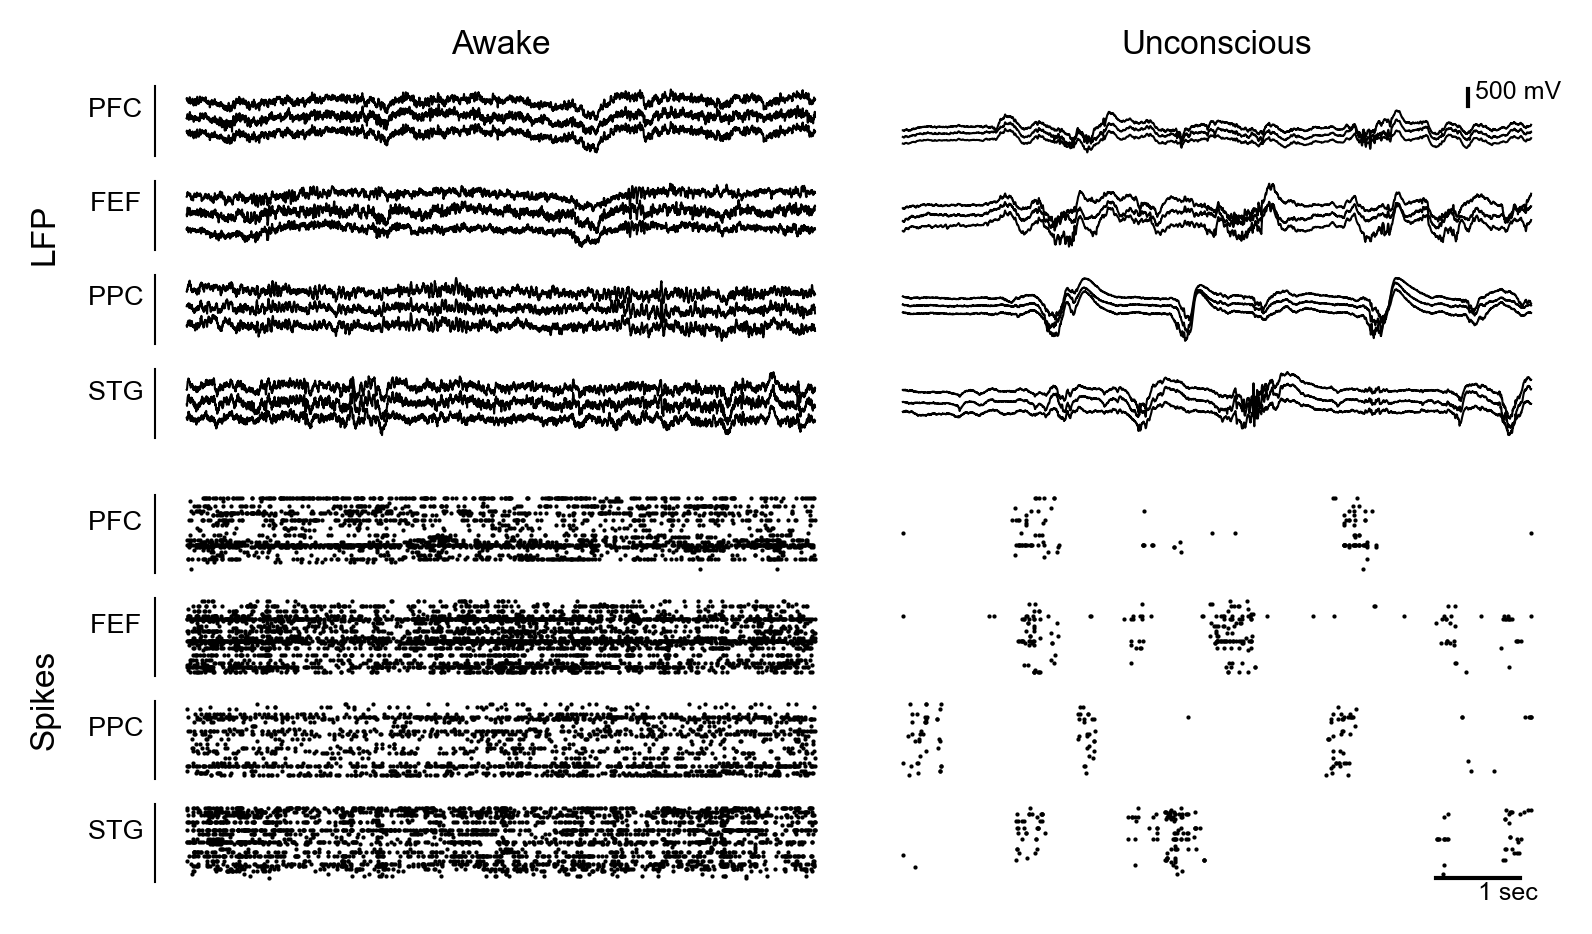

In [15]:
# %matplotlib inline
plt.style.use('../sci_style.py')
fig = plt.figure(layout='constrained', figsize=(5, 3))
subfigs = fig.subfigures(1, 1, hspace=0.07)

onplot_fontsize = 6
marker_size = 1
marker_width = 0.01
onplot_width = 1
superylabel_fontsize = 8

shift = 0.2

# ------------------------------------------
# IMAGES
# ------------------------------------------

# ------------------------------------------
# NEURAL DATA
# ------------------------------------------

nested_subfigs = subfigs.subfigures(2, 1, hspace=0.07)

areas = ['vlPFC', 'FEF', '7b', 'CPB']
axs = nested_subfigs[0].subplots(4, 2, sharey=False)
for j, area in enumerate(areas):
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]

    ax = axs[j][0]
    inds = np.random.choice(unit_indices, size=(3,), replace=False)
    for n, ind in enumerate(inds):
        # print(lfp[int(start_wake/dt):int((start_wake + 10)/dt), ind].shape)
        # ax.plot(lfp[int(start_wake/dt):int((start_wake + 10)/dt), ind] - n*shift, c='k', linewidth=plot_width)
        ax.plot(lfp[int(start_wake/dt):int((start_wake + 10)/dt), ind] - n*shift, c='k')
    
    # ax.spines[['right', 'top', 'bottom']].set_visible(False)
    ax.spines[['bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # Set the thickness of the axis lines
    # ax.spines['left'].set_linewidth(yaxis_width)   # Thickness of left spine
    
    ax.set_ylabel(f"{area_labels[area]}    ", rotation=0)
    
    if j == 0:
        # ax.set_title('Awake', fontsize=title_fontsize)
        ax.set_title('Awake')
    
    ax = axs[j][1]
    inds = np.random.choice(unit_indices, size=(3,), replace=False)
    for n, ind in enumerate(inds):
        # ax.plot(lfp[int(start_anesthesia/dt):int((start_anesthesia + 10)/dt), ind] - n*shift, c='k', linewidth=plot_width)
        ax.plot(lfp[int(start_anesthesia/dt):int((start_anesthesia + 10)/dt), ind] - n*shift, c='k')
    
    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
        ax.set_title('Unconscious')
        max_val = lfp[int(start_wake/dt):int((start_wake + 10)/dt), inds[-1]].max()
        bar_verts = [max_val + 0.5, max_val + 1]
        ax.plot([int(10/dt)*0.9, int(10/dt)*0.9], bar_verts, c='k', linewidth=onplot_width)
        # ax.text(int(10/dt)*0.91, np.mean(bar_verts), "500 mV", fontsize=onplot_fontsize)
        ax.text(int(10/dt)*0.91, np.mean(bar_verts), "500 mV")
# nested_subfigs[0].text(-0.03, 0.5, "LFP", va='center', fontsize=superylabel_fontsize, rotation=90)
nested_subfigs[0].text(-0.03, 0.5, "LFP", va='center', fontsize=superylabel_fontsize, rotation=90)

axs = nested_subfigs[1].subplots(4, 2)
for j, area in enumerate(areas):
    ax = axs[j][0]
    # ax.spines[['right', 'top', 'bottom']].set_visible(False)
    ax.spines[['bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.spines['left'].set_linewidth(yaxis_width)   # Thickness of left spine
    # ax.set_ylabel(f"{area_labels[area]}    ", fontsize=ylabel_fontsize, rotation=0)
    ax.set_ylabel(f"{area_labels[area]}    ", rotation=0)
    
    if area == 'all':
        unit_indices = np.arange(len(unit_info['area']))
    else:
        unit_indices = np.where(unit_info['area'] == area)[0]
    unit_indices = np.random.choice(unit_indices, size=(30,), replace=False)
    
    for n, unit_ind in enumerate(unit_indices):
        spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_wake, spike_times[unit_ind] <= start_wake + 10)]
        spike_ts = (spike_ts - start_wake)/dt
        ax.scatter(spike_ts, [n]*len(spike_ts), marker='o', facecolors='k', c='k', linewidth=marker_width, s=marker_size)

    ax = axs[j][1]
    # ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    ax.spines[['bottom', 'left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    for n, unit_ind in enumerate(unit_indices):
        spike_ts = spike_times[unit_ind][np.logical_and(spike_times[unit_ind] >= start_anesthesia, spike_times[unit_ind] <= start_anesthesia + 10)]
        spike_ts = (spike_ts - start_anesthesia)/dt
        ax.scatter(spike_ts, [n]*len(spike_ts), marker='o', facecolors='k', c='k', linewidth=marker_width, s=marker_size)
    
    xmax = ax.get_xlim()[1]
    ymin = ax.get_ylim()[0]
    if j == 3:
#         ax.set_title('Unconscious', fontsize=title_fontsize)
#         bar_verts = [max_val + 0.5, max_val + 1]
        ax.plot([xmax - 10000*0.15, xmax - 10000*0.05], [-2.13, -2.13], c='k', linewidth=onplot_width)
        # ax.text(xmax - 10000*0.1, -11, "1 sec", fontsize=onplot_fontsize)
        ax.text(xmax - 10000*0.1, -11.13, "1 sec")
    
nested_subfigs[1].text(-0.03, 0.5, "Spikes", va='center', fontsize=superylabel_fontsize, rotation=90)
# plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, 'main', 'neural-sample.pdf'), bbox_inches='tight', transparent=True, dpi=500)

bbox = fig.get_tightbbox(fig.canvas.get_renderer())
# Calculate width and height of the bounding box in inches
width_inches = (bbox.x1 - bbox.x0)
height_inches = (bbox.y1 - bbox.y0)
print(width_inches, height_inches)

plt.show()